Main issue:
"Understanding why and when employees are most likely to leave can lead to actions to improve employee retention as well as planning new hiring in advance."
"In this challenge, you have a data set with info about the employees and have to predict when employees are going to quit by understanding the main drivers of employee churn."

Questions:
"The goal is to predict employee retention and understand its main drivers."

### Exploratory Data Analysis
Load in the data, and get summary stats and visualizations!

In [91]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
from time import gmtime, strftime
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

In [92]:
# Load in data
test = pd.read_csv('/Users/katelyons/Documents/Insight/data challenges/18C/data_challenge_3/employee_retention.csv',index_col=0)

In [93]:
# We see quit_date NaN means "still working" --> might want to transform this to a new column of working yes/no
test.sample(10)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
13699,1007637.0,10,temp_contractor,0,6008.0,2009-01-25,2009-04-25
24073,773772.0,2,sales,27,160000.0,2014-11-24,NaN
13929,764183.0,9,customer_service,1,25000.0,2012-03-19,NaN
10838,858024.0,6,customer_service,16,90000.0,2015-08-31,NaN
22211,946149.0,3,engineer,13,150000.0,2015-05-26,NaN
31982,62581.0,1,sales,23,192000.0,09.14.2015,NaN
2449,1000321.0,3,temp_contractor,0,6735.0,2010-06-06,2010-09-04
7450,330865.0,8,marketing,6,107000.0,2013-11-11,2015-01-09
31875,411907.0,1,marketing,10,122000.0,04.02.2013,2015-04-10
26882,69693.0,7,customer_service,6,54000.0,2014-03-31,NaN


#### Note: join_date is formatted weirdly ... do we need this? 
¯\\_(ツ)_/¯ 

In [94]:
test.dtypes

employee_id    float64
company_id       int64
dept            object
seniority        int64
salary         float64
join_date       object
quit_date       object
dtype: object

In [95]:
# Make sure everything is in the right format -- employee_id and company_id should be objects 
test['employee_id'] = test.employee_id.astype('object')
test['company_id'] = test.company_id.astype('object')

#### To visualize patterns of churn by time, I want to create a new variable of "quit / hasn't quit"

In [96]:
test["status"] = test.quit_date.fillna("working")
test.loc[test['status'].str.contains('-'), 'status'] = 'quit'

In [97]:
# Check for missing values
test.isnull().any()

employee_id    False
company_id     False
dept           False
seniority      False
salary          True
join_date      False
quit_date       True
status         False
dtype: bool

We have missing data on quit_date, but that is okay because that just means people are still working. We also have missing data on salaries... let's see how much.

In [98]:
print (test.shape)
test.salary.isnull().sum()/34702

(34702, 8)


0.006887211111751484

Okay, only .6% of our employee data is missing, which isn't too bad. We might be able to infer what their salary was by k-means clustering with other people who have similar backgrounds, years of experience, etc. but that will be on the back-burner until we actually get something to answer the main questions.

In [99]:
# Duplicates in our data?
test.employee_id.duplicated().values.any()

False

In [100]:
# Number of employees
test['employee_id'].nunique()

34702

In [101]:
# Check out categories of what we are dealing with
test['dept'].unique()

array(['temp_contractor', 'design', 'engineer', 'marketing',
       'customer_service', 'data_science', 'sales'], dtype=object)

These all seem independent, don't have to worry about anything here.

In [102]:
# Break down of departments
test['dept'].value_counts()

temp_contractor     10000
customer_service     9180
engineer             4613
data_science         3190
sales                3172
marketing            3167
design               1380
Name: dept, dtype: int64

## HOLD THE PHONE!
If you are a 'temp' contractor, doesn't that mean you'll automatically have quit?
Let's look at the breakdown of temp_contractors...

In [103]:
pd.crosstab(test.dept, test.status, margins=True)

status,quit,working,All
dept,,,
customer_service,5094,4086,9180
data_science,1682,1508,3190
design,778,602,1380
engineer,2362,2251,4613
marketing,1783,1384,3167
sales,1811,1361,3172
temp_contractor,10000,0,10000
All,23510,11192,34702


#### Success! We see temp_contractors all are not working... !
Let's get rid of temp_contractors ALL TOGETHER!

In [104]:
test = test[~test.dept.str.contains("temp_contractor")]

In [105]:
# How many companies do we have?
test['company_id'].nunique()

12

In [106]:
# Breakdown of company data
test['company_id'].value_counts()

1     8486
2     4222
3     2749
4     2062
5     1755
6     1291
7     1224
8     1047
9      961
10     865
12      24
11      16
Name: company_id, dtype: int64

In [107]:
# Graph employee churn over time
# Let's create two data frames, one that has people who quit, one who has people who stayed?
test['status'].value_counts()

quit       13510
working    11192
Name: status, dtype: int64

In [108]:
# Check out aspects of the people who quit
test.groupby('status').mean()

,seniority,salary
status,,
quit,14.131458,135726.511697
working,14.123392,141192.259112


Great! This doesn't tell us anything, which is cool. Maybe there is more information in breakdowns of categorical aspects.

Customer service people make the least money on average, 

#### Visualization
Let's see how often people leave by department! Help from [here](https://towardsdatascience.com/predict-employee-turnover-with-python-da4975588aa3). (I honestly don't think this is cheating, if you find an example that is really similar to the thing you are doing and you managed to find it, isn't that good?)

Text(0,0.5,'Frequency of Churn')

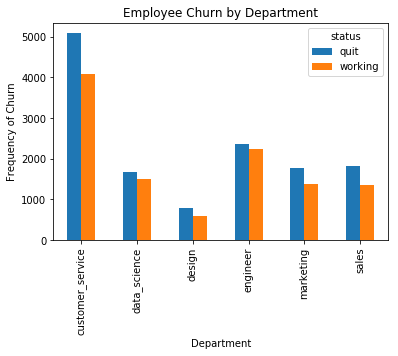

In [109]:
%matplotlib inline
import matplotlib.pyplot as plt
pd.crosstab(test.dept,test.status).plot(kind='bar')
plt.title('Employee Churn by Department')
plt.xlabel('Department')
plt.ylabel('Frequency of Churn')

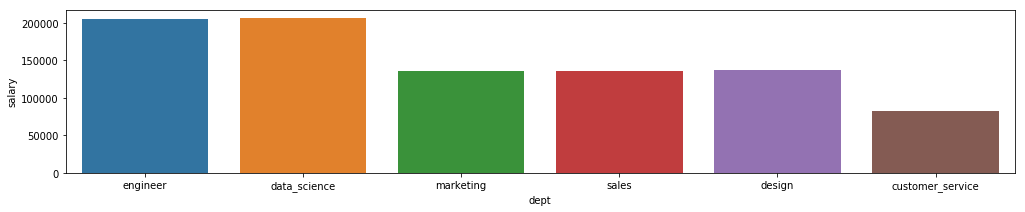

In [110]:
# Let's also look at salaries by department
pd_df = test.sort_values(by = 'salary', ascending = False).reset_index(drop=True)
plt.figure(figsize=(17,3))
sns.barplot(x="dept", y="salary", data=pd_df, ci = None)

#### Observations so far:
- Data scienctists and engineers make the most money, but engineers leave more than data scientists do
- Customer service makes less than everyone, and leaves the most
- Design people have the least churn

Does TIME have anything to do with anything? Want to just check to be sure...

In [111]:
# Graph things over time
# Use datetime for creating date objects for plotting
import datetime
# Want to get a break down of month and year
# Get counts per company of people who quit in monthly chunks
# Make date date
quit_dates = test.dropna(axis=0)

quit_dates['quit_date']  = pd.to_datetime(quit_dates['quit_date'])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


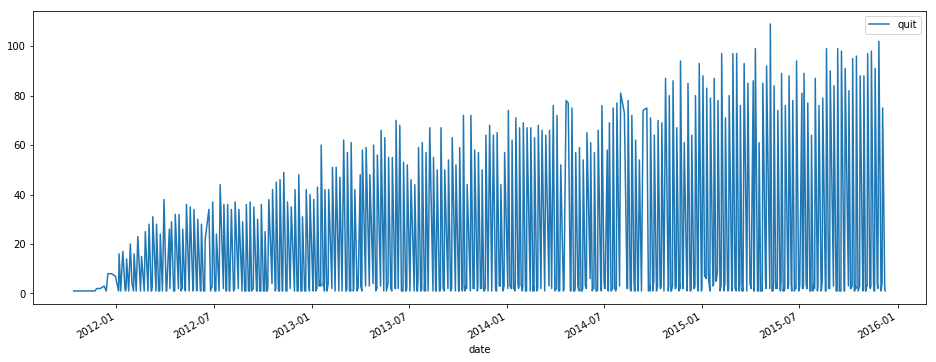

In [112]:
plot_data = pd.crosstab(quit_dates.quit_date,quit_dates.status)
plot_data.index.name = None
plot_data = plot_data.reset_index()
plot_data.columns = ['date','quit']
plot_data.set_index('date').plot(figsize = [16,6])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


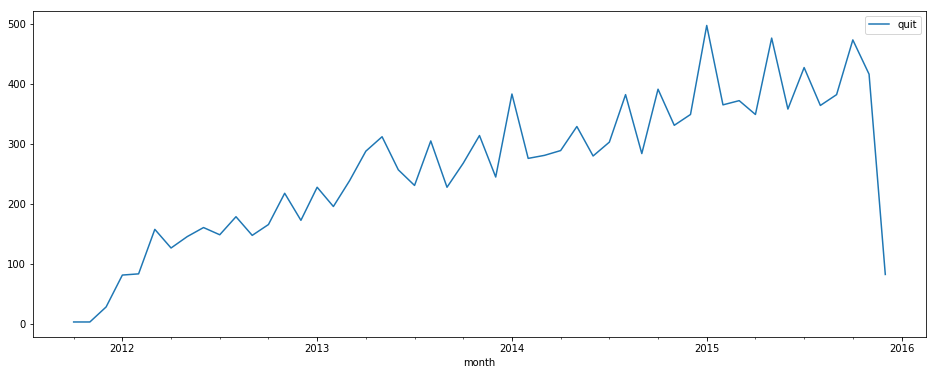

In [113]:
# Kind of messy, let's group by month 
quit_dates['month'] = quit_dates.quit_date.dt.to_period('M')
plot_data2 = pd.crosstab(quit_dates.month,quit_dates.status)
plot_data.index.name = None
plot_data2 = plot_data2.reset_index()
plot_data2.columns = ['month','quit']
plot_data2.set_index('month').plot(figsize = [16,6])

In [114]:
# Check out break down of individual companies
group_by_company = quit_dates.groupby(['company_id','status'])
group_by_company.size()

company_id  status
1           quit      4582
2           quit      2181
3           quit      1519
4           quit      1142
5           quit       976
6           quit       703
7           quit       683
8           quit       568
9           quit       524
10          quit       477
11          quit        12
12          quit        12
dtype: int64

Check out by month as well (help from [here](https://community.modeanalytics.com/python/tutorial/pandas-groupby-and-python-lambda-functions/)).

In [115]:
company_quit_by_month = quit_dates.pivot_table(index='month', columns='company_id', values='status', aggfunc='count')
company_quit_by_month.fillna("0")

company_id,1,2,3,4,5,6,7,8,9,10,11,12
month,,,,,,,,,,,,
2011-10,1.0,0,0,1,0,1,0,0,0,1,0,0
2011-11,3.0,1,0,0,0,0,0,0,0,0,0,0
2011-12,8.0,4,2,5,1,2,1,5,0,1,0,0
2012-01,30.0,16,9,5,5,3,7,4,3,0,0,0
2012-02,28.0,13,13,6,9,5,1,3,4,1,0,1
2012-03,56.0,14,22,11,11,13,8,10,5,8,0,0
2012-04,46.0,14,15,9,8,11,9,7,5,3,0,0
2012-05,42.0,24,20,11,12,10,9,3,10,3,0,2
2012-06,63.0,27,15,14,9,7,6,4,9,7,0,0


Companies 11 and 12 don't have that much information. Should we drop them? Also company 1 has A LOT more people quitting that other companies do...

Another note of interest is that month DOES seem to have some impact maybe? There is some variation here that might be informative. We'll come back to this if we have more time, as time of year probably isn't the biggest driver of employees leaving.

#### Feature engineering part 2?
Maybe instead of WHEN people quit, it's interesting to think about how long someone has worked at the company when they have quit. This seems to be an important thing this data set is missing!

In [116]:
# Let's just work with our quit_dates data frame bc we only want quitters
quitters = quit_dates
# Turn dots into dashes?
# Check easier way first
quitters['join_date'] = pd.to_datetime(quitters['join_date'])
# Sweet! We don't even have to change things :D

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Help computing time difference from [here](https://stackoverflow.com/questions/1345827/how-do-i-find-the-time-difference-between-two-datetime-objects-in-python) and [here](https://stackoverflow.com/questions/25646200/python-convert-timedelta-to-int-in-a-dataframe).

In [117]:
from datetime import timedelta
# time_difference = a - b
# time_difference_in_minutes = time_difference / timedelta(minutes=1)
quitters['days_worked'] = quitters['quit_date'] - quitters['join_date']
quitters['days_worked'] = quitters.days_worked.dt.days

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [118]:
quitters.sample(10)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,status,month,days_worked
101,732641,1,data_science,11,176000.0,2012-01-30,2014-12-03,quit,2014-12,1038
21263,861281,1,customer_service,29,128000.0,2012-04-17,2013-04-26,quit,2013-04,374
23801,958473,3,customer_service,25,107000.0,2012-02-27,2014-12-05,quit,2014-12,1012
27720,734260,1,data_science,3,69000.0,2011-09-26,2014-03-07,quit,2014-03,893
34406,366037,6,sales,14,101000.0,2014-07-14,2015-06-10,quit,2015-06,331
17597,303968,2,customer_service,15,104000.0,2011-03-21,2013-03-22,quit,2013-03,732
16359,94458,1,data_science,2,72000.0,2012-03-26,2014-02-21,quit,2014-02,697
31831,232556,1,marketing,17,208000.0,2015-01-12,2015-11-27,quit,2015-11,319
7407,591856,6,engineer,26,197000.0,2013-05-06,2014-03-12,quit,2014-03,310
20816,559640,3,engineer,12,156000.0,2011-12-19,2013-01-11,quit,2013-01,389


In [119]:
# Merge this with original dataframe
# Want to do left bc we want to fill employee_ids that are still working with NaNs
quitters2 = quitters[['employee_id', 'days_worked']]
test2 =  test.merge(quitters2, how='left', on = 'employee_id')
test2.sample(10)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,status,days_worked
23565,562435,1,marketing,1,48000.0,03.09.2015,NaN,working,NaN
8275,727430,1,marketing,4,53000.0,2015-11-09,NaN,working,NaN
10243,199374,2,sales,15,238000.0,2011-08-08,2012-08-24,quit,382.0
8577,100080,1,customer_service,12,66000.0,2013-05-06,NaN,working,NaN
18099,985535,2,data_science,2,82000.0,11.19.2012,2015-03-06,quit,837.0
4281,858800,3,customer_service,12,62000.0,2014-01-15,NaN,working,NaN
11764,954469,1,engineer,6,170000.0,2014-08-11,NaN,working,NaN
13520,439392,3,data_science,7,149000.0,2013-09-16,2014-10-10,quit,389.0
5292,943188,5,customer_service,3,22000.0,2014-12-08,NaN,working,NaN
21999,48341,7,customer_service,13,63000.0,2014-11-11,NaN,working,NaN


#### How do we treat currently working employees?
We want to keep this data I think in our model bc it might be a good predictor of churn... we know we have data until December 13 2015, so what we could do is make that a fake 'quit_date' to generate how many days they've worked. 

In [120]:
# Just do everything over again so as to do both -- fixing a mistake...
test2 = test
test2["quit_date"] = test2.quit_date.fillna("2015-12-13")
test2['join_date'] = pd.to_datetime(test2['join_date'])
test2['quit_date'] = pd.to_datetime(test2['quit_date'])
test2['days_worked'] = test2['quit_date'] - test2['join_date']
test2['days_worked'] = test2.days_worked.dt.days

In [121]:
test2.sample(10)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,status,days_worked
8641,994035,2,customer_service,18,137000.0,2012-08-13,2014-04-04,quit,599
29627,179025,7,customer_service,22,94000.0,2013-05-13,2015-02-06,quit,634
27464,651918,7,data_science,15,239000.0,2013-11-25,2015-07-10,quit,592
17660,411516,2,customer_service,8,78000.0,2015-11-02,2015-12-13,working,41
9943,649068,2,design,16,230000.0,2012-10-30,2013-10-25,quit,360
15064,910750,1,customer_service,13,79000.0,2011-08-22,2014-09-05,quit,1110
28104,64878,1,sales,6,119000.0,2015-03-16,2015-12-13,working,272
7452,943188,5,customer_service,3,22000.0,2014-12-08,2015-12-13,working,370
16943,324708,10,marketing,2,38000.0,2013-07-15,2015-12-13,working,881
764,997781,3,marketing,7,126000.0,2015-10-05,2015-12-13,working,69


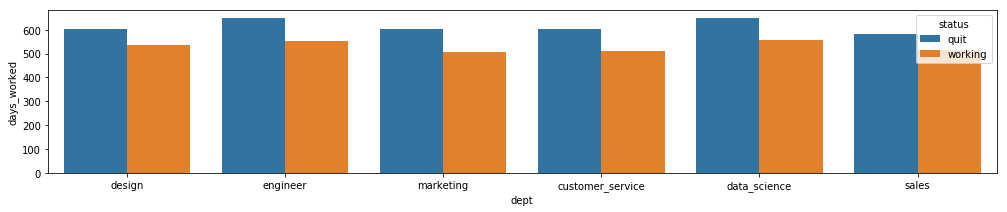

In [122]:
# Graph it!
plt.figure(figsize=(17,3))
sns.barplot(x="dept", y="days_worked", hue="status", data=test2, ci = None)

This is good and interesting! We see that people who have worked more days are more likely to quit, perhaps? I think days worked seems to potentially be something of interest...

### Modeling
I think we can be ready to figure out what might be the strongest indicators of whether or not someone will leave.

First we'll one-hot-encode our categorical variables, and then assess which ones are good predictors of our outcome.

We have a TON of categorical variables, so we will definitely want to reduce these down just to the ones are good at predicting what we are interested in.

(Remember we won't use employee_id ... maybe keep company_id?)

In [123]:
test2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24702 entries, 1 to 34701
Data columns (total 9 columns):
employee_id    24702 non-null object
company_id     24702 non-null object
dept           24702 non-null object
seniority      24702 non-null int64
salary         24463 non-null float64
join_date      24702 non-null datetime64[ns]
quit_date      24702 non-null datetime64[ns]
status         24702 non-null object
days_worked    24702 non-null int64
dtypes: datetime64[ns](2), float64(1), int64(2), object(4)
memory usage: 2.5+ MB


In [124]:
cat_vars=['company_id','dept']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(test2[var], prefix=var)
    test1=test2.join(cat_list)

In [125]:
# Get rid of dept after one-hot-encoding as well as employee_id and dates
test1.drop(test.columns[[0,2,5,6]], axis=1, inplace=True)
test1

,company_id,seniority,salary,status,days_worked,dept_customer_service,dept_data_science,dept_design,dept_engineer,dept_marketing,dept_sales
1,8,21,191000.0,quit,304,0,0,1,0,0,0
2,3,9,90000.0,quit,1110,0,0,1,0,0,0
3,2,20,298000.0,quit,662,0,0,0,1,0,0
5,5,20,180000.0,working,531,0,0,0,0,1,0
6,3,18,119000.0,quit,634,1,0,0,0,0,0
7,7,7,140000.0,quit,612,0,1,0,0,0,0
8,10,16,238000.0,working,720,0,1,0,0,0,0
9,5,28,166000.0,working,165,0,0,0,0,0,1
10,2,3,77000.0,working,132,0,1,0,0,0,0
11,3,13,162000.0,quit,312,0,1,0,0,0,0


Our outcome variable is status, and everything else is a predictor.

In [135]:
test_vars=test1.columns.values.tolist()
y=['status']
X=[i for i in test_vars if i not in y]

#### Feature Selection
We are using Recursive Feature Elimination: "works by recursively removing variables and building a model on those variables that remain. It uses the model accuracy to identify which variables (and combination of variables) contribute the most to predicting the target attribute." (from [here](https://towardsdatascience.com/predict-employee-turnover-with-python-da4975588aa3))

We have 11 columns, let's narrow it down to 10. (This is more for later reference when we have more predictor variables!)

In [136]:
# To make things easier
hr = test1
# Drop rows we don't have salary data for
hr = hr.dropna(axis=0)

In [137]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
rfe = RFE(model, 10)
rfe = rfe.fit(hr[X], hr[y])
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1 1]


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


We already have 10, that's why all of them are 1. We'll keep this for later reference if needed tho!
If we wanted to use it, we'd just use those columns it identified with a 1!

In [ ]:
# Example of what you'd do
# cols=['satisfaction_level', 'last_evaluation', 'time_spend_company', 'Work_accident', 'promotion_last_5years', 
#       'department_RandD', 'department_hr', 'department_management', 'salary_high', 'salary_low'] 
# X=hr[cols]
# y=hr['left']

In [138]:
# HAVE TO DO THIS ANYWAY -- creates dataframes to work with for your model
X = hr[X]
y = hr[y]

In [ ]:
# To make things easier to interpret later on
# y = y.rename(columns={'status':'quitters'})
test_set = {'quit'}

y['quitters'] = y['status'].apply(lambda x: sum(i in test_set for i in x.split()))
y = y[['quitters']]
# 0 is stayed, 1 is quit

#### Logistic Regression Model

In [140]:
import sklearn
from sklearn.model_selection import train_test_split # Training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
from sklearn.linear_model import LogisticRegression # Get the model
from sklearn import metrics # Metrics, to get metrics?
logreg = LogisticRegression() # Say, this is the model we are using
logreg.fit(X_train, y_train.values.ravel()) # Fit this on our training data

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [141]:
from sklearn.metrics import accuracy_score # Get how accurate our model was
print('Logistic regression accuracy: {:.3f}'.format(accuracy_score(y_test, logreg.predict(X_test))))

Logistic regression accuracy: 0.618


#### Random Forest

In [144]:
# Don't have to do that much work, because we have already split things
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [145]:
print('Random Forest Accuracy: {:.3f}'.format(accuracy_score(y_test, rf.predict(X_test))))

Random Forest Accuracy: 0.727


#### Support Vector Machine

In [146]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, y_train.values.ravel())

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [147]:
print('Support vector machine accuracy: {:.3f}'.format(accuracy_score(y_test, svc.predict(X_test))))

Support vector machine accuracy: 0.547


From [Stack Exchange](https://datascience.stackexchange.com/questions/26640/how-to-check-for-overfitting-with-svm-and-iris-data):

"You check for hints of overfitting by using a training set and a test set (or a training, validation and test set). As others have mentioned, you can either split the data into training and test sets, or use cross-fold validation to get a more accurate assessment of your classifier's performance.

Since your dataset is small, splitting your data into training and test sets isn't recommended. Use cross validation.

This can be done using either the cross_validate or cross_val_score function; the latter providing multiple metrics for evaluation. In addition to test scores the latter also provides fit times and score times."

In [167]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(svc, X, y.values.ravel(), cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.55 (+/- 0.00)


#### Model Selection
We see that the logistic regression is the most accurate, so we'll go with that one!

Maybe... we also want to *cross validate!*

"Cross validating attempts to avoid overfitting while still producing a prediction for each observation dataset. We are using 10-fold Cross-Validation to train our Random Forest model."

In [148]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = RandomForestClassifier()
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_train, y_train.values.ravel(), cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

10-fold cross validation average accuracy: 0.716


"10-fold cross validation average accuracy: 0.716
The average accuracy remains very close to the Random Forest model accuracy (0.727); hence, we can conclude that the model generalizes well."

#### READ UP ON WHY / HOW THIS WORKS ^

#### Precision and Recall
"We construct confusion matrix to visualize predictions made by a classifier and evaluate the accuracy of a classification."

In [149]:
from sklearn.metrics import classification_report
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.71      0.69      0.70      3401
           1       0.74      0.76      0.75      3938

   micro avg       0.73      0.73      0.73      7339
   macro avg       0.73      0.72      0.73      7339
weighted avg       0.73      0.73      0.73      7339



What this is telling us is our precision (the number of true postives divided by true postives + false positives -- the smaller this is, we are making mistakes in terms of Type 1 errors) and recall (number of true postives divided by true postives + false negatives -- the smaller this is, the more type 2 errors we are making).
So we see for times when people actually quit (1) our model does better in both precision and recall (reflected in higher f1-score too).
We also see that Random Forest is doing better consistently across these categories. It also does better at RECALL (makes less type 2 errors -- so doesn't say that someone will not leave when they actually will) than precision (saying someone will leave when they won't) so that is good for our purposes.

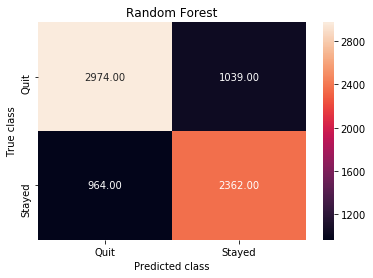

In [153]:
# Graph this
y_pred = rf.predict(X_test)
from sklearn.metrics import confusion_matrix
import seaborn as sns
forest_cm = metrics.confusion_matrix(y_pred, y_test, [1,0])
sns.heatmap(forest_cm, annot=True, fmt='.2f',xticklabels = ["Quit", "Stayed"] , yticklabels = ["Quit", "Stayed"] )
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('Random Forest')
plt.savefig('random_forest')

To interpret this, the upper left is TRUE POSITIVES -- times we said true when true, times we said people quit and they quit. The upper right is times we messed up (it is good that it is darker then, smaller than times we said true when true) and said that someone stayed when they actually QUIT (false negative, a.k.a. TYPE 2 error!). The bottom left is false postives -- times when we said someone quit and they actually stayed. This is a false postive or a TYPE 1 ERROR...

This graph is weird tho, I think I'd do it the other way with the false positive on the upper right and false negative on the lower left. But always just important to read the labels I guess.

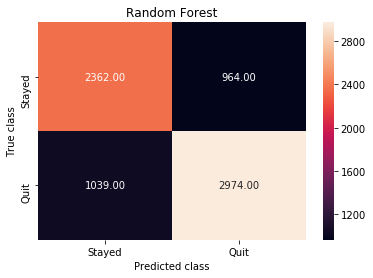

In [155]:
# Like so !
y_pred = rf.predict(X_test)
from sklearn.metrics import confusion_matrix
import seaborn as sns
forest_cm = metrics.confusion_matrix(y_pred, y_test, [0,1])
sns.heatmap(forest_cm, annot=True, fmt='.2f',xticklabels = ["Stayed", "Quit"] , yticklabels = ["Stayed", "Quit"] )
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('Random Forest')
plt.savefig('random_forest')

In [156]:
# Let's look at logistic regression version
print(classification_report(y_test, logreg.predict(X_test)))

              precision    recall  f1-score   support

           0       0.70      0.31      0.43      3401
           1       0.60      0.88      0.71      3938

   micro avg       0.62      0.62      0.62      7339
   macro avg       0.65      0.60      0.57      7339
weighted avg       0.64      0.62      0.58      7339



Weirdly, logistic regression shows a much better f1-score for predicting when someone is going to LEAVE. 

Also we see that our recall is better, which means that this model is making less type 2 errors than it is making type 1 errors. So the logistic regression in general is making mistakes in saying "person will quit!" when actually they aren't, and making less errors in saying "person will not quit!" when they will. For our purposes, this is okay, we don't need to mess with the probability threshold ... (depends on the context tho and resources used to go after people thinking to quit!)

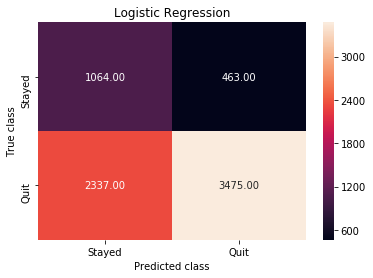

In [157]:
logreg_y_pred = logreg.predict(X_test)
logreg_cm = metrics.confusion_matrix(logreg_y_pred, y_test, [0,1])
sns.heatmap(logreg_cm, annot=True, fmt='.2f',xticklabels = ["Stayed", "Quit"] , yticklabels = ["Stayed", "Quit"] )
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('Logistic Regression')
plt.savefig('logistic_regression')

Logistic Regression actually seems to do better than Random Forest in the false positives department -- it is better at not making the mistake of identifing someone as a quitter who will actually stay.

It's good though for the random forest to make more errors there (we don't mind if we are bugging people who aren't going to quit to not quit, better to do that than miss out on people who truly WILL quit). Random forest is worse in this type 2 error department than type 1s as well, BUT overall number of type 2 errors (false negatives) is less for RF.

In [158]:
print(classification_report(y_test, svc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.64      0.05      0.10      3401
           1       0.54      0.97      0.70      3938

   micro avg       0.55      0.55      0.55      7339
   macro avg       0.59      0.51      0.40      7339
weighted avg       0.59      0.55      0.42      7339



Is it weird that SVM is much better at the positive cases than negative ones?

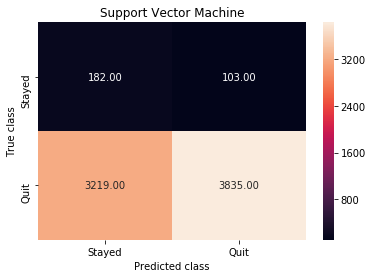

In [159]:
svc_y_pred = svc.predict(X_test)
svc_cm = metrics.confusion_matrix(svc_y_pred, y_test, [0,1])
sns.heatmap(svc_cm, annot=True, fmt='.2f',xticklabels = ["Stayed", "Quit"] , yticklabels = ["Stayed", "Quit"] )
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('Support Vector Machine')
plt.savefig('support_vector_machine')

Have I messed something up? :O SVM is just way better at dealing with positive cases (times when people have quit)... which suggests the model might be overfitted I think. Might not be the best for predicting future data. 

We have a big type 2 error going on here (a high number in lower left), so might make the model more liberal, decrease the probability threshold a bit...

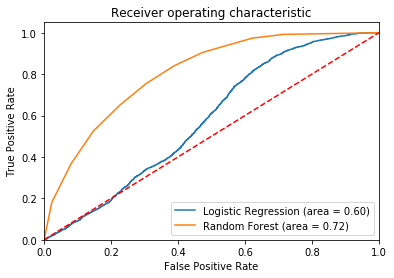

In [160]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot(rf_fpr, rf_tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('ROC')
plt.show()

"The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner)."

#### Feature Importances for Random Forest Model
Now we've decided what model we are going with, we can use the feature importances feature to see the most influential reasons why people quit!

In [165]:
feature_labels = np.array(['company_id', 'seniority', 'salary', 'days_worked',
       'dept_customer_service', 'dept_data_science', 'dept_design',
       'dept_engineer', 'dept_marketing', 'dept_sales'])
importance = rf.feature_importances_
feature_indexes_by_importance = importance.argsort()
for index in feature_indexes_by_importance:
    print('{}-{:.2f}%'.format(feature_labels[index], (importance[index] *100.0)))

dept_customer_service-0.39%
dept_data_science-0.40%
dept_sales-0.41%
dept_design-0.42%
dept_marketing-0.44%
dept_engineer-0.45%
company_id-6.56%
seniority-12.00%
salary-20.43%
days_worked-58.50%


Interestingly, or maybe not people all the people currently working have worked the same amount of days so that is a good predictor of whether or not they will have stayed...

ALSO AS LAUREN POINTED OUT WE WONT REALLY KNOW HOW MANY DAYS A PERSON WILL BE WITH A COMPANY... SO NOT A GOOD THING TO INCLUDE IN OUR MODEL?

Salary and seniority are big ones too, as is what company you are dealing with. Variable that might be helpful is an employee satisfaction metric or how big the company is or why they left!

TO DO IN FUTURE: Ditch the how many days worked, break up companies perhaps?